In [2]:
from scipy import *
import numpy as np
from matplotlib import pyplot as pt
from matplotlib.colors import LinearSegmentedColormap
import time

class fractal2D:
    def partialDerivatives(self,x,y):

        """
        function that calculates the Jacobian of a DIFFERENTIABLE function
        Author: Nadine
        Inputs
        ======
        x,y - floats/ integers
        
        Outputs        
        ======
        J - Jacobian (partial derivatives) of a function
        """
        #print(type(x))  #if there is an error message here, print x to check the type
        if not (isinstance(x,(int,float,np.int64,np.float64,np.int32,np.float32)) and isinstance(y,(int,float,np.int64,np.float64,np.int32,np.float32))):
            raise TypeError('The two input variables must be integers or floats.')
            
        f=self.function
        J=zeros(2)
        h=1e-10
        J=1/h*array([f(x+h,y)-f(x,y),f(x,y+h)-f(x,y)]).T
        return J
        
    def __init__(self, f, derivative = None):
        """
        f : function taking a tuple and returning a tuple
        der : derivative of the function taking a tuple and returning a 2x2 matrix (Jacobian matrix)
        """
        self.function = f
        self.zeros = np.array([[ ]])
        if derivative==None:
            self.derivative=self.partialDerivatives
        else:
            self.derivative=derivative
    
    def newtonMethod(self,guess):
        """
        function that carries out the newton integration method
        Author: Edmund
        Inputs
        ======
        guess - tuple, list or 1-dimensional array of length 2 with float/ integer entries
        
        Outputs        
        ======
        zero - loaction of zero, returns None if the guess did not converge (tuple)
        """
        if isinstance(guess,(list,tuple,np.ndarray)) and size(guess)==2:
            guess=array(guess)
        else:
            raise TypeError('The initial guess is not of the correct type. It must be a list with two integer/ float entries, a tuple or an array of size (2,)')
        
        maxloop = 1000
        new_guess = array([0,0]) #initiate value here so that it dose not get reinitiated for each loop (to improve performance)
        for i in range(maxloop):
            Jacobian=self.derivative(guess[0],guess[1])
            if np.linalg.det(Jacobian)==0:
                return None,maxloop
            else:
                Jacobian_inv=np.linalg.inv(Jacobian)
            new_guess = guess - np.matmul(Jacobian_inv,self.function(guess[0],guess[1]))#should work but need a R^2 function and derivative to test...

            if np.abs(new_guess[0]-guess[0]) < 10**(-5) and np.abs(new_guess[1]-guess[1]) < 10**(-5): #close enough to a zero value...
                return new_guess , i
            guess = new_guess
        else:
            return None,maxloop # return None if did not converge

  
    
  
    def find_zero(self, guess, simple_newton = 0):
        """
        function that carries out the newton integration method
        Author: Edmund
        Inputs
        ======
        guess - initial guess to for a zero
        
        Output
        ======
        returns index of zero, None if point did not converge
        """
        #val , i = self.newton(guess)
        val , i = self.newton(guess)
        tol = 10**(-5)  # tolerance value...
        if val is None: # value did not converge
            return -1,i
        if self.zeros.size == 0:
            self.zeros = np.array([val])
        t = (self.zeros-val)**2
        dist = t[:,0] + t[:,1]
        if (dist<tol).any() : #zero exists
            return np.where(dist<tol)[0][0] , i
        else:  # value dose not exist yet
            self.zeros=np.reshape(np.append(self.zeros,val),(-1,2)) #add value to zeros
            return self.zeros.size/2-1 , i 
    
    def call_findZero(self,A,B,simple = False):
        """
        a helper function such we can vectorise without an error
        """
        #self.curr += 1
        #print(self.curr, " out of ", self.max)
        return (self.find_zero((A,B),simple)) 

    def plot(self, N, a, b, c, d, simple_newton = False, show_plot = True):
        """
        where N eventually determines the size of the matrix and a,b,c,d are the maually
        given intervals (a,c) corresponds to the bottom left corner of the grid 
        and (b,d) the top right corner of the grid
        """
        #implementing simplified newton, implemented in this way to speed up computations
        if simple_newton == 1:                                                  
                 self.newton =  self.simpleNewtonMethod                              
        elif simple_newton == 2:                                                
             self.newton = self.optimised
        else:
            self.newton =  self.newtonMethod
        #used for tracking progress...
        #self.max = N**2
        #self.curr = 0

        Y, X=np.meshgrid(linspace(a,b,N),linspace(c,d,N),indexing='ij')
        """
        Gives the transpposed matrices X and Y
        """
        v_zeroes=np.vectorize(self.call_findZero)
        """ vectorizes the function v_zeroes
        """
        #print(Y)
        #print(type(Y))
        A, B=(v_zeroes(X,Y,simple_newton))
        """
        creats matrix A 
        """
        if show_plot:
            B = ((B-1)%10)/10
            color_map = pt.cm.get_cmap('Set1')
            color_map.set_under('0')
            pcol = pt.pcolormesh(X,Y,A,cmap=pt.cm.Set1,edgecolor = 'face', linewidth=0,rasterized=True, vmin=0,vmax = A.max())
            pt.colorbar() 
            #make custom color map
            custom = [(0,(0, 0, 0, 0)), (1,(0, 0, 0, 0.5))]
            my_cmap = LinearSegmentedColormap.from_list('something',custom)
            pcol = pt.pcolormesh(X,Y,B,edgecolor = 'face',cmap=my_cmap,linewidth=0,rasterized=True)
            pt.show()
        return A,B
    

    def simpleNewtonMethod(self,guess):
        """
        function that carries out the newton integration method
        Author: Edmund
        Inputs
        ======
        guess - tuple, list or 1-dimensional array of length 2 with float/ integer entries
        
        Outputs        
        ======
        zero - loaction of zero, returns None if the guess did not converge (tuple)
        """
        if isinstance(guess,(list,tuple,np.ndarray)) and size(guess)==2:
            guess=np.array(guess)
        else:
            raise TypeError('The initial guess is not of the correct type. It must be a list with two integer/ float entries, a tuple or an array of size (2,)')
        
        maxloop = 1000
        new_guess = np.array([0,0]) #initiate value here so that it dose not get reinitiated for each loop (to improve performance)
        Jacobian=self.derivative(guess[0],guess[1])
        if np.linalg.det(Jacobian)==0:  
            return None,maxloop
        else:
            Jacobian_inv=np.linalg.inv(Jacobian)
        for i in range(maxloop):
            new_guess = guess - np.matmul(Jacobian_inv,self.function(guess[0],guess[1]))#should work but need a R^2 function and derivative to test...
            if (np.abs(new_guess)>1e+30).any():
                return None,maxloop
            if np.abs(new_guess[0]-guess[0]) < 10**(-4) and np.abs(new_guess[1]-guess[1]) < 10**(-5): #close enough to a zero value...
                return new_guess , i
            guess = new_guess
        else:
            return None,maxloop # return None if did not converge
        
    def optimised(self,guess):                                                  
        ret_val, i = self.simpleNewtonMethod(guess)   
        if isinstance(ret_val,(np.ndarray)):                                                    
            return ret_val, i                                                   
        else :                                                                  
            return self.newtonMethod(guess) 
            
def f(x,y):
    return np.array([x**3-3*x*y**2-1,3*x**2*y-y**3])
k = fractal2D(f)
#k.plot(250,-0.5,0.5,-0.5,0.5,True)
def diff(guess):
    print("Diff:", k.simpleNewtonMethod(guess)-k.newtonMethod(guess))

def g(x,y):
    return np.array([(x**3)-(3*x)*(y**2)-(2*x)-2,3*(x**2)*y-(y**3)-2*y])
l=fractal2D(g)

def h(x,y):
    return np.array([x**8-28*x**6*y**2+70*x**4*y**4+15*x**4-28*x**2*y**6-90*x**2*y**2+y**8+15*y**4-16,8*x**7*y-56*x**5*y**3+56*x**3*y**5+60*x**3*y-8*x*y**7-60*x*y**3])
m=fractal2D(h)

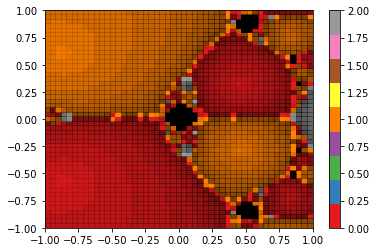

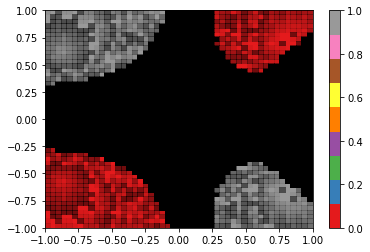

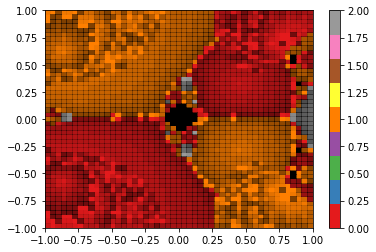

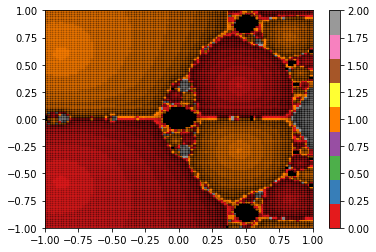

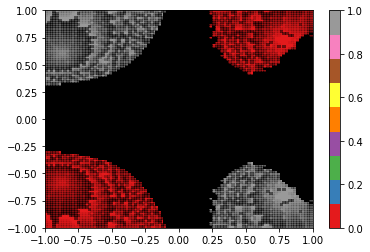

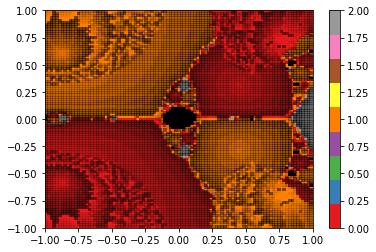

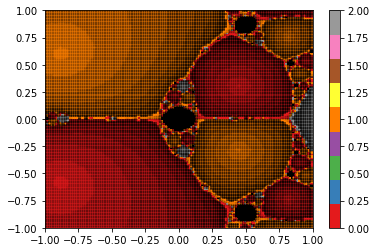

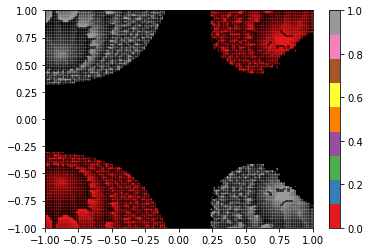

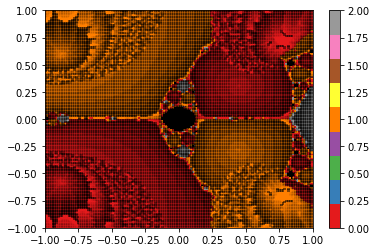

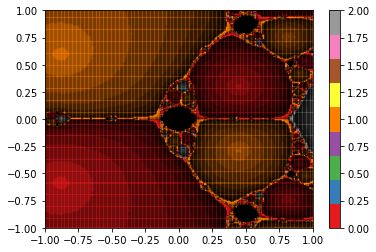

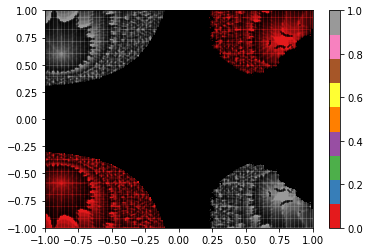

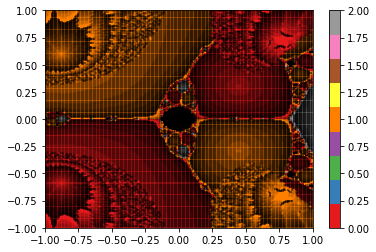

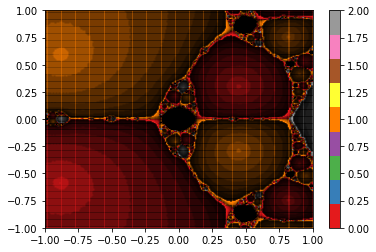

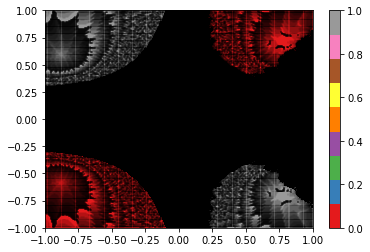

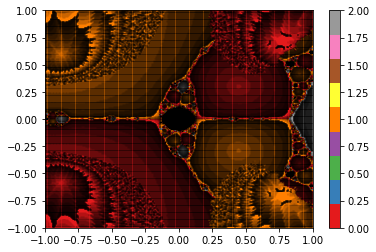

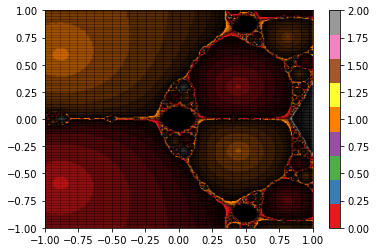

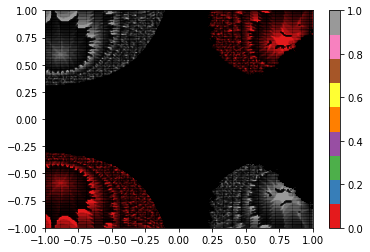

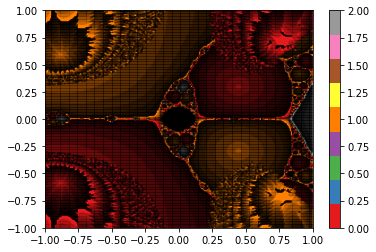

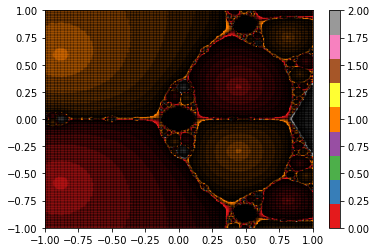

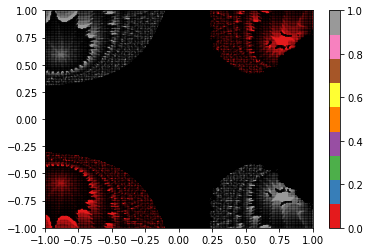

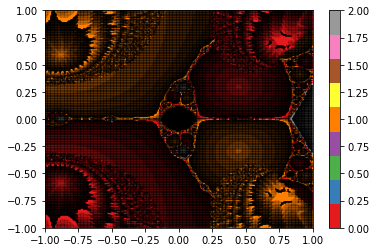

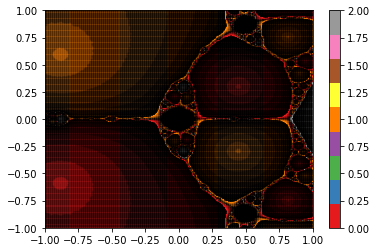

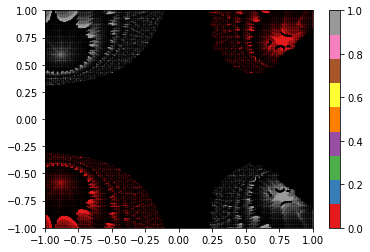

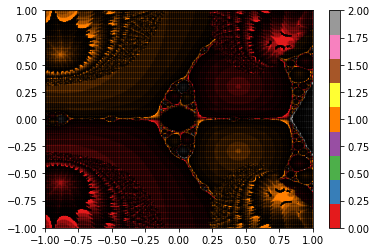

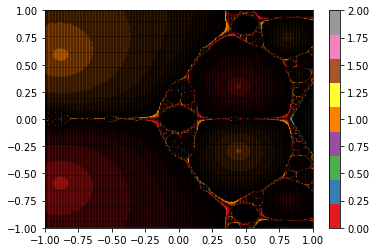

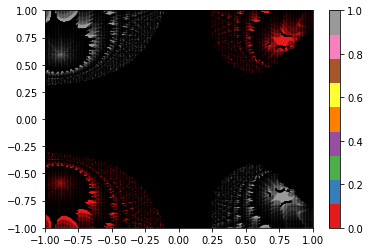

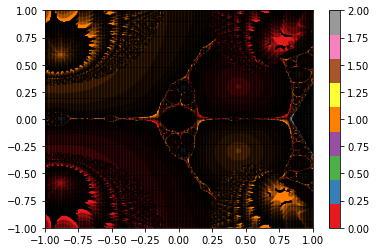

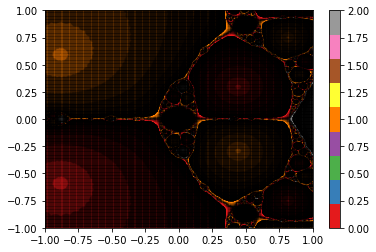

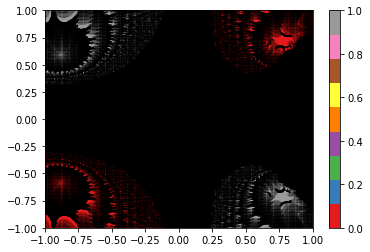

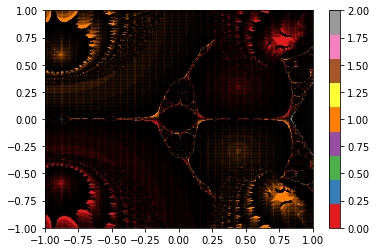

Text(0.5,1,'Execution time for different implementations')

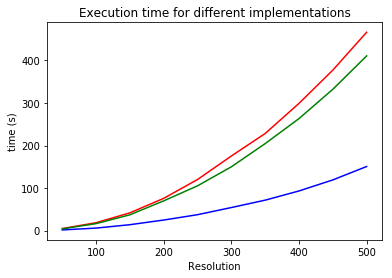

In [3]:
n=[]
s=[]
o=[]
N=[]

for i in range (50,550, 50):
    N.append(i)
    start = time.time()
    l.plot(i,-1,1,-1,1,0)
    end = time.time()
    n.append(end-start)
    
    start = time.time()
    l.plot(i,-1,1,-1,1,1)
    end = time.time()
    s.append(end-start)
    
    start = time.time()
    l.plot(i,-1,1,-1,1,2)
    end = time.time()
    o.append(end-start)
    
    
pt.plot(N,n,'r', label='Newton method')
pt.plot(N,s,'b',label='Simplified Newton method')
pt.plot(N,o,'g',label='Optimized Newton method')
pt.xlabel('Resolution')
pt.ylabel('time (s)')
pt.title('Execution time for different implementations')
pt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    

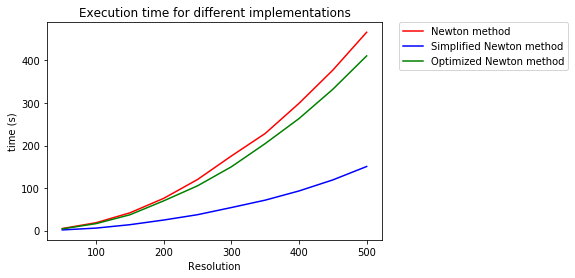

In [6]:
pt.plot(N,n,'r', label='Newton method')
pt.plot(N,s,'b',label='Simplified Newton method')
pt.plot(N,o,'g',label='Optimized Newton method')
pt.xlabel('Resolution')
pt.ylabel('time (s)')
pt.title('Execution time for different implementations')
pt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


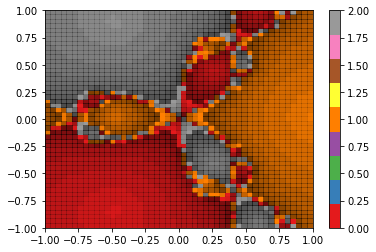

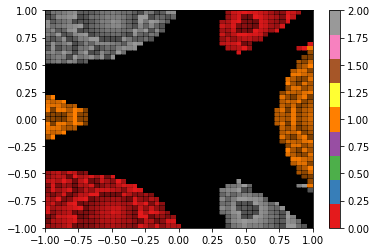

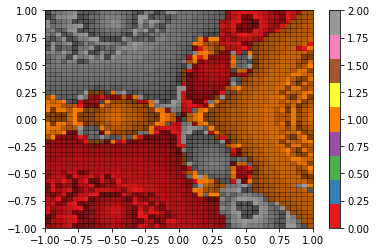

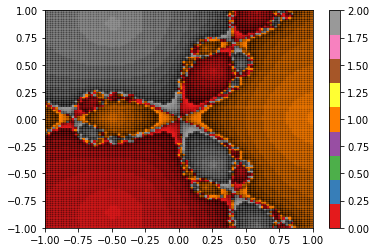

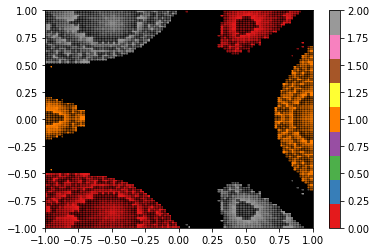

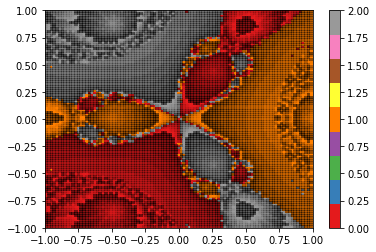

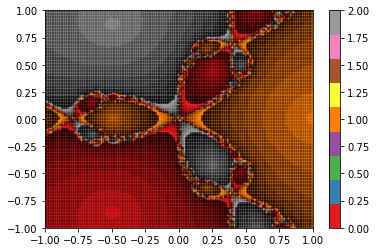

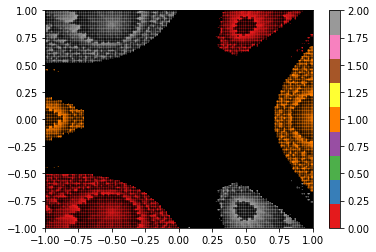

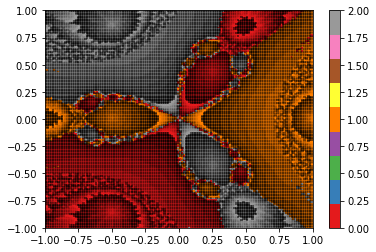

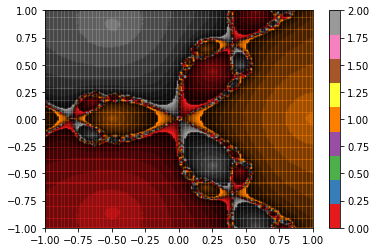

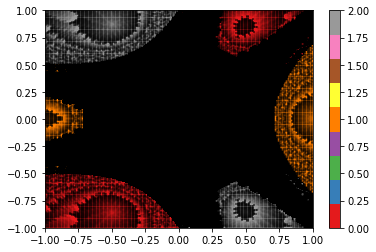

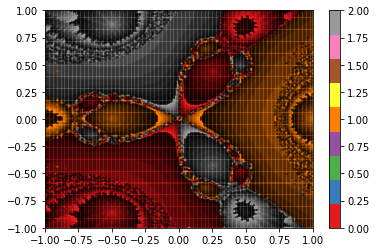

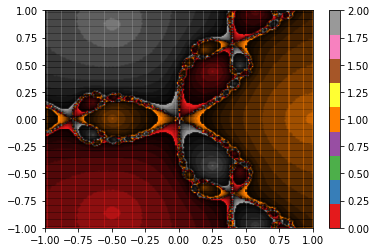

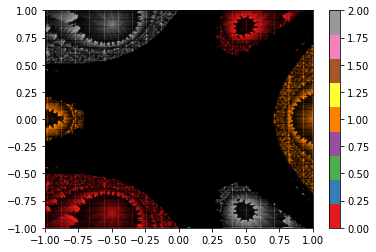

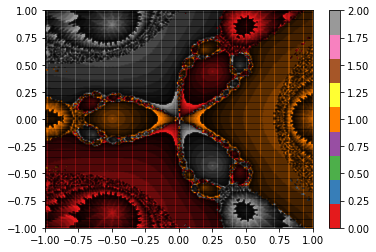

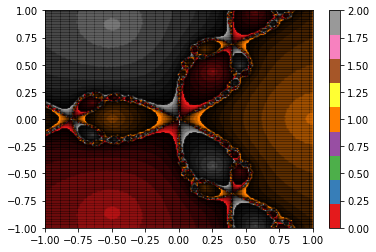

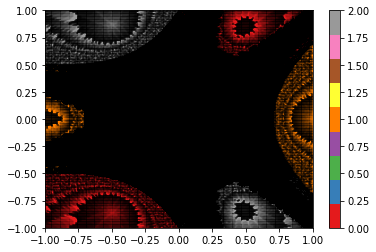

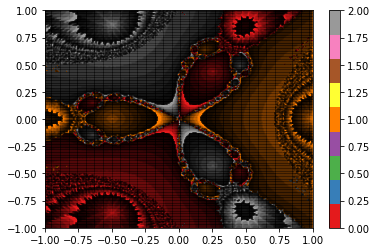

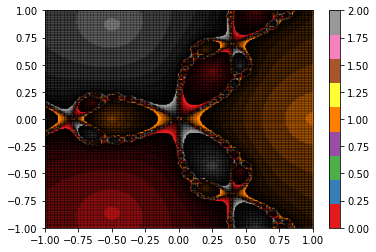

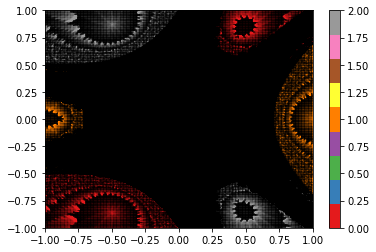

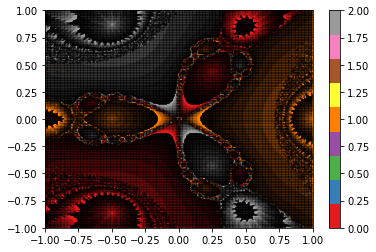

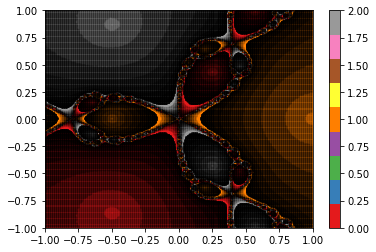

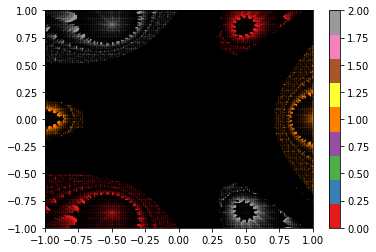

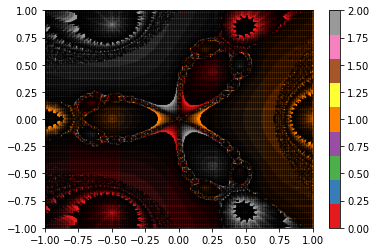

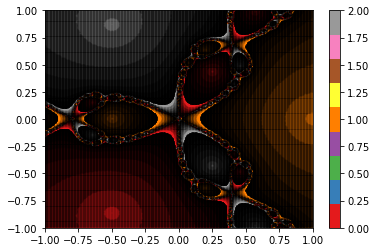

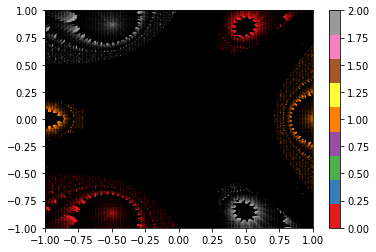

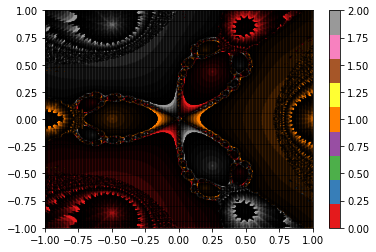

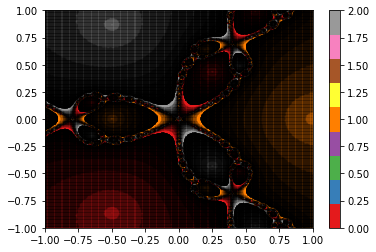

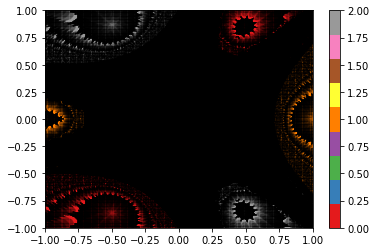

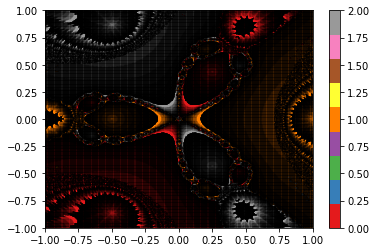

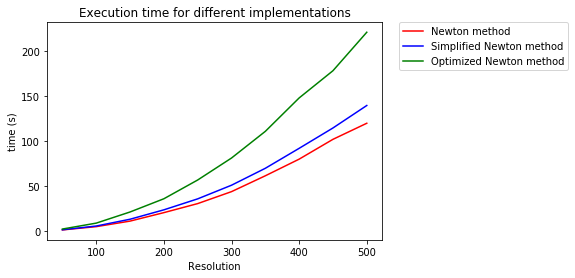

In [7]:
n=[]
s=[]
o=[]
N=[]

for i in range (50,550, 50):
    N.append(i)
    start = time.time()
    k.plot(i,-1,1,-1,1,0)
    end = time.time()
    n.append(end-start)
    
    start = time.time()
    k.plot(i,-1,1,-1,1,1)
    end = time.time()
    s.append(end-start)
    
    start = time.time()
    k.plot(i,-1,1,-1,1,2)
    end = time.time()
    o.append(end-start)
    
    
pt.plot(N,n,'r', label='Newton method')
pt.plot(N,s,'b',label='Simplified Newton method')
pt.plot(N,o,'g',label='Optimized Newton method')
pt.xlabel('Resolution')
pt.ylabel('time (s)')
pt.title('Execution time for different implementations')
pt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

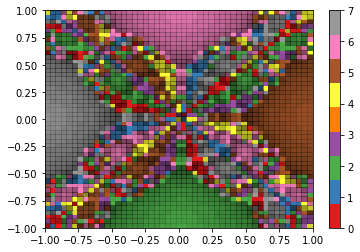

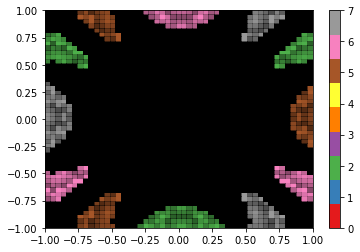

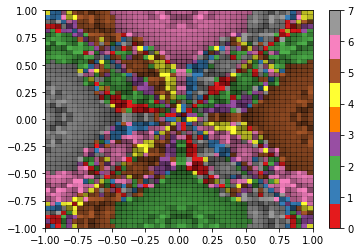

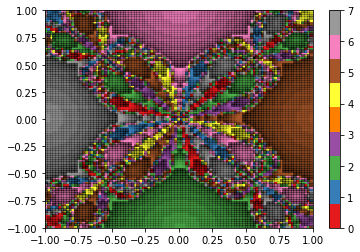

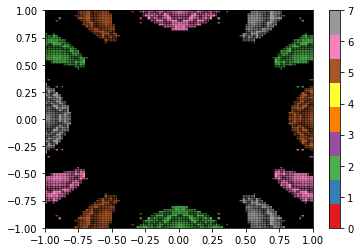

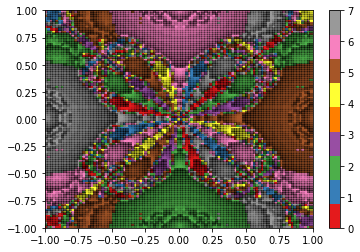

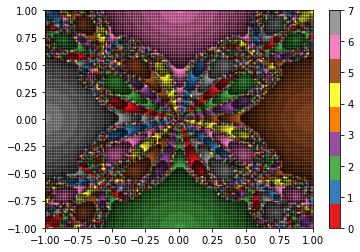

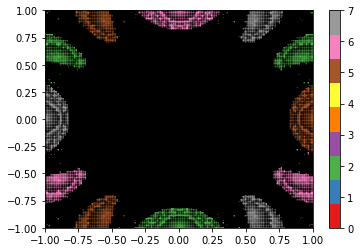

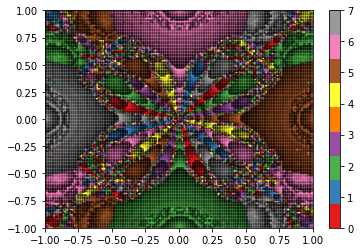

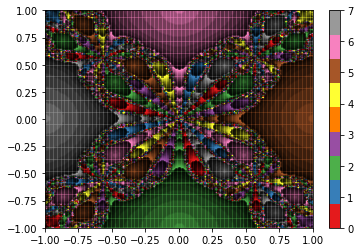

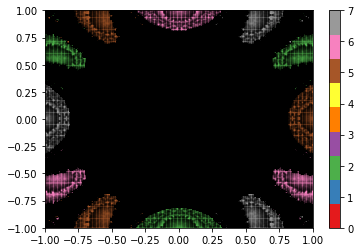

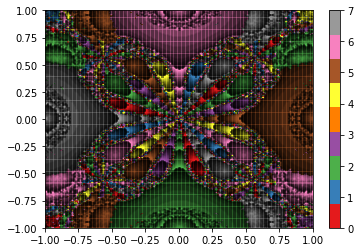

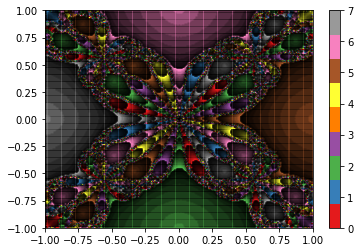

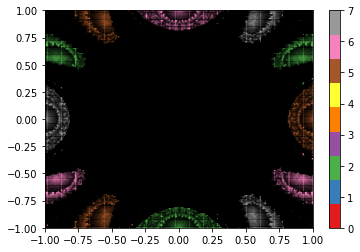

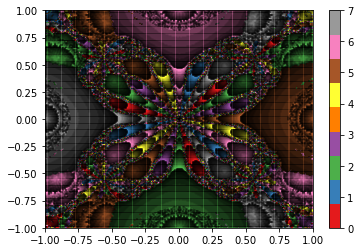

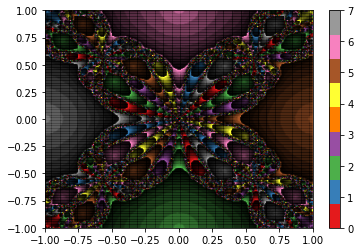

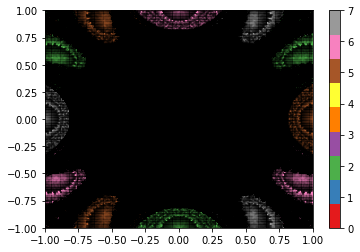

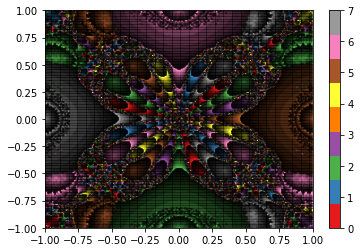

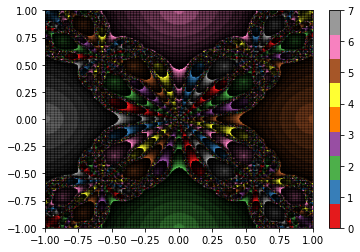

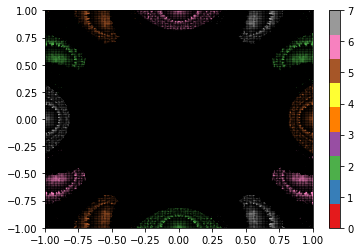

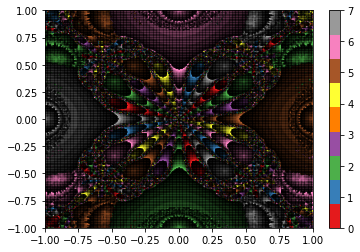

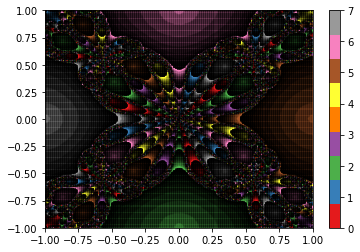

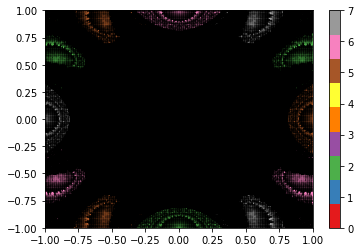

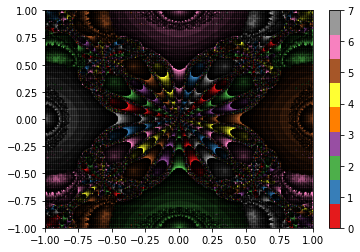

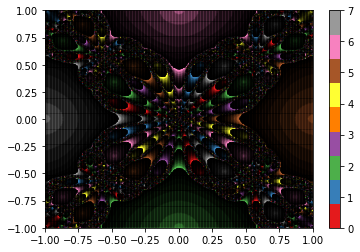

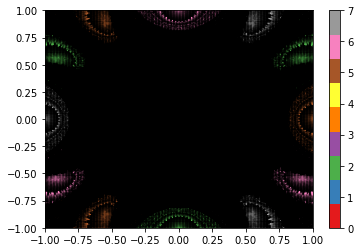

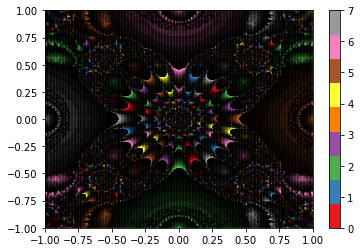

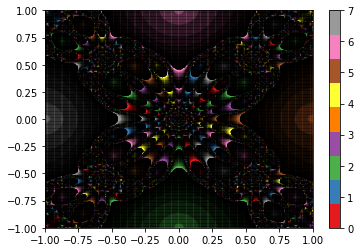

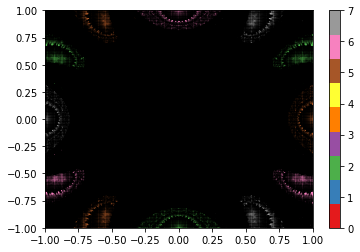

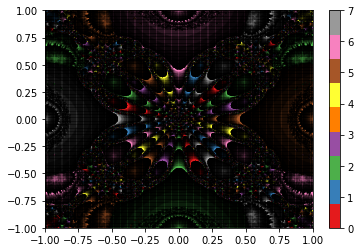

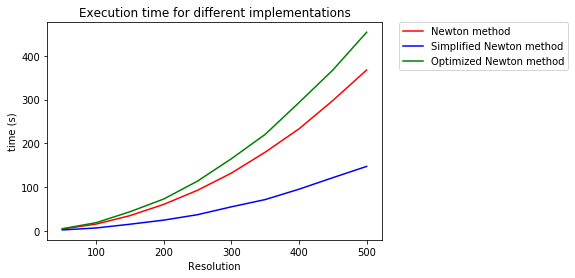

In [8]:
nm=[]
sm=[]
om=[]
N=[]

for i in range (50,550, 50):
    N.append(i)
    start = time.time()
    m.plot(i,-1,1,-1,1,0)
    end = time.time()
    nm.append(end-start)
    
    start = time.time()
    m.plot(i,-1,1,-1,1,1)
    end = time.time()
    sm.append(end-start)
    
    start = time.time()
    m.plot(i,-1,1,-1,1,2)
    end = time.time()
    om.append(end-start)
    
    
pt.plot(N,nm,'r', label='Newton method')
pt.plot(N,sm,'b',label='Simplified Newton method')
pt.plot(N,om,'g',label='Optimized Newton method')
pt.xlabel('Resolution')
pt.ylabel('time (s)')
pt.title('Execution time for different implementations')
pt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)